# Alzheimer Disease Detection using Ensemble Learning

## Import Libraries

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
import io
import seaborn as sns

from sklearn.utils import shuffle # Shuffle arrays or sparse matrices in a consistent way
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import DenseNet121
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard,ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.utils.vis_utils import plot_model

import ipywidgets as widgets
from PIL import Image
from IPython.display import display, clear_output

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Define Labels

In [3]:
labels = ['Final AD JPEG','Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG','Final MCI JPEG']

In [4]:
X_train = [] #Training Dataset
Y_train = [] #Training Labels

image_size=150

for i in labels:
    folderPath = os.path.join('/kaggle/input/alzheimers-adni/Alzheimers-ADNI/', 'train', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/alzheimers-adni/Alzheimers-ADNI', 'test', i) # Join two or more pathname components
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
# converted into array

Xtrain = np.array(X_train)
Ytrain = np.array(Y_train)

100%|██████████| 233/233 [00:01<00:00, 137.60it/s]


In [5]:
Xtrain.shape

(18775, 150, 150, 3)

In [6]:
Ytrain.shape

(18775,)

In [7]:
Xtrain, Ytrain = shuffle(Xtrain, Ytrain, random_state=42)

## Train test split which is divided train dataset and validation dataset

In [8]:
xtrain,xtest, Ytrain,ytest = train_test_split(Xtrain, Ytrain,test_size=0.3, random_state=42)

In [9]:
xtrain.shape

(13142, 150, 150, 3)

In [10]:
Ytrain.shape

(13142,)

In [11]:
xtest.shape

(5633, 150, 150, 3)

In [12]:
ytest.shape

(5633,)

## Converting labels into One hot encoder

In [13]:
ytrain_new = []
ytest_new = []

for i in Ytrain:
    ytrain_new.append(labels.index(i))#Converting String Label to integer i.e
                                       
ytrain = to_categorical(ytrain_new) #Converts a class vector (integers) to binary class matrix

for i in ytest:
    ytest_new.append(labels.index(i))

ytest = to_categorical(ytest_new)

In [14]:
ytrain.shape

(13142, 5)

In [15]:
ytest.shape

(5633, 5)

# DENSENET MODEL

In [16]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(image_size, image_size, 3)) 

29084464/29084464 [==============================] - 1s 0us/step


In [17]:
# Output of model

model = model_d.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(5, activation='softmax')(model)
model = tf.keras.models.Model(inputs=model_d.input, outputs=model)

In [18]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

In [19]:
model.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [20]:
history = model.load_weights('/kaggle/input/model-training/Model Training/densenet.h5')

In [21]:
labels_final = ['AD','CN','EMCI','LMCI','MCI']

## Classification Report - Densenet Model

In [22]:
pred = model.predict(xtest)
pred = np.argmax(pred, axis=1)
actual_label = np.argmax(ytest, axis=1)
print(classification_report(actual_label, pred , target_names = labels))

177/177 [==============================] - 12s 29ms/step
                 precision    recall  f1-score   support

  Final AD JPEG       0.99      0.93      0.96      2481
  Final CN JPEG       0.94      0.98      0.96      2603
Final EMCI JPEG       0.57      0.78      0.66       130
Final LMCI JPEG       0.78      0.65      0.71        43
 Final MCI JPEG       0.83      0.76      0.80       376

       accuracy                           0.94      5633
      macro avg       0.82      0.82      0.82      5633
   weighted avg       0.94      0.94      0.94      5633



In [23]:
accuracy_score(actual_label, pred)

0.938398721817859

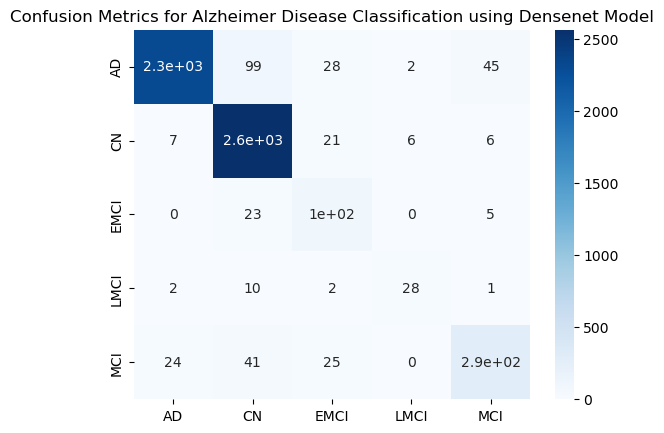

In [24]:
Cm=confusion_matrix(actual_label,pred)
ax=plt.axes()
sns.heatmap(Cm, cmap='Blues' ,annot=True,
           annot_kws={'size':10},
           xticklabels=labels_final,
           yticklabels=labels_final,
           ax=ax
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using Densenet Model")
plt.savefig('densenet_confusion.png', dpi=300) # Save plot as PNG
plt.show()

## Loss and Accuracy Measurement graph

In [25]:
import pickle

with open('/kaggle/input/model-training/Model Training/densenet_history.pkl', 'rb') as f:
    history = pickle.load(f)

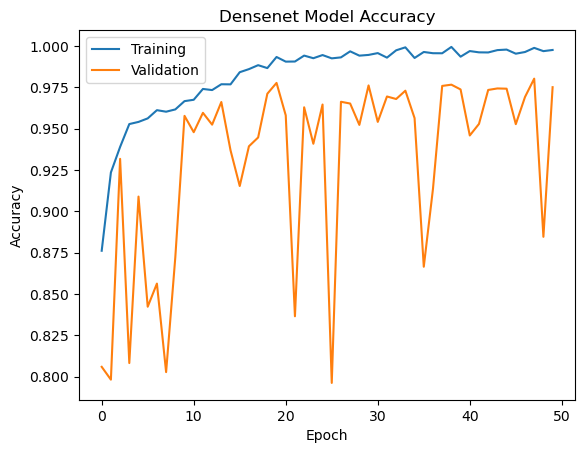

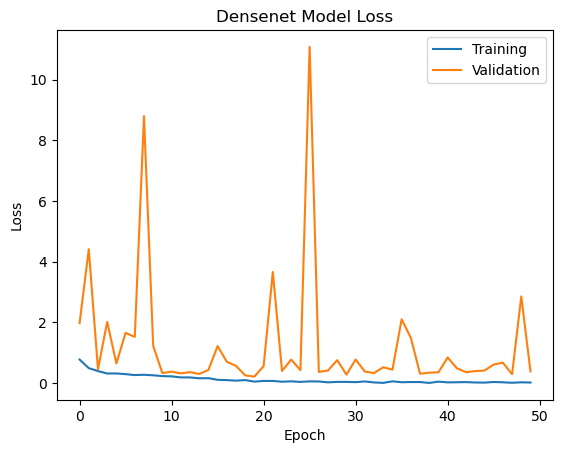

In [26]:
# Plot the training and validation accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Densenet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('densenet_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Densenet Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('densenet_loss.png', dpi=300) # Save plot as PNG
plt.show()

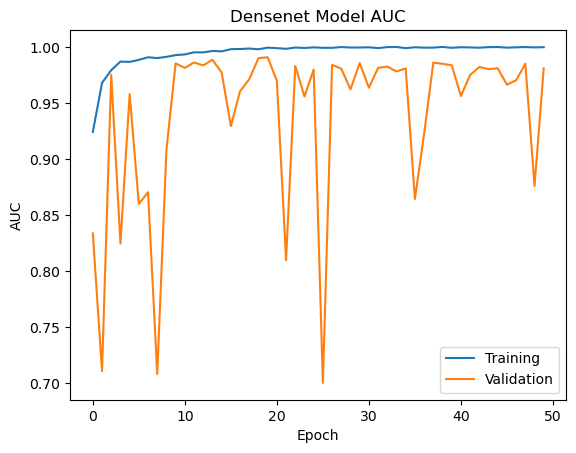

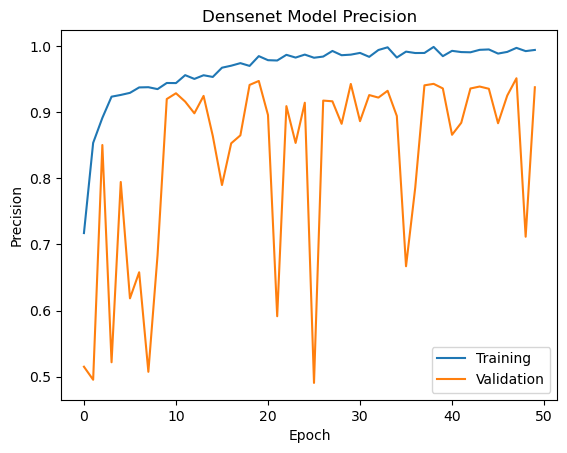

In [27]:
# Plot the training and validation auc
plt.plot(history['auc'])
plt.plot(history['val_auc'])
plt.title('Densenet Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('densenet_auc.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(history['precision'])
plt.plot(history['val_precision'])
plt.title('Densenet Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('densenet_precision.png', dpi=300) # Save plot as PNG
plt.show()

## CNN MODEL

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers

model1 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(image_size, image_size, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

In [29]:
model1.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [30]:
history1 = model1.load_weights('/kaggle/input/model-training/Model Training/cnn.h5')


## Classification Report - CNN Model

In [31]:
pred1 = model1.predict(xtest)
pred1 = np.argmax(pred1, axis=1)
actual_label1 = np.argmax(ytest, axis=1)
print(classification_report(actual_label1, pred1 , target_names = labels_final))

177/177 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

          AD       0.95      0.89      0.92      2481
          CN       0.89      0.97      0.93      2603
        EMCI       0.77      0.63      0.69       130
        LMCI       1.00      0.65      0.79        43
         MCI       0.86      0.71      0.78       376

    accuracy                           0.91      5633
   macro avg       0.89      0.77      0.82      5633
weighted avg       0.91      0.91      0.91      5633



In [32]:
accuracy_score(actual_label1, pred1)

0.9098171489437245

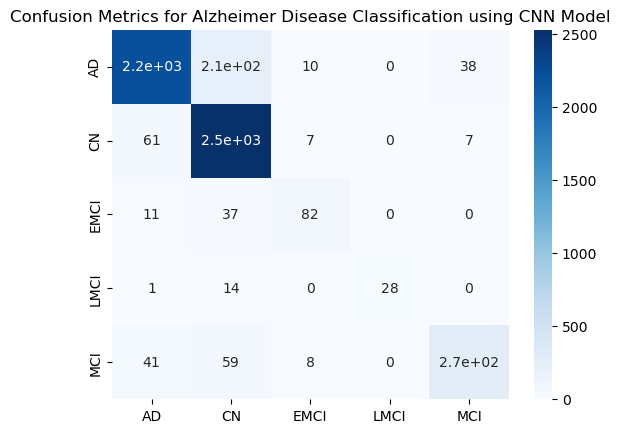

In [33]:
Cm1=confusion_matrix(actual_label1,pred1)
ax1=plt.axes()
sns.heatmap(Cm1, cmap='Blues' ,annot=True,
           annot_kws={'size':10},
           xticklabels=labels_final,
           yticklabels=labels_final,
           ax=ax1
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using CNN Model")
plt.savefig('cnn_confusion.png', dpi=300) # Save plot as PNG
plt.show()

## Loss and Accuracy Measurement Graph - CNN Model

In [34]:
import pickle

with open('/kaggle/input/model-training/Model Training/cnn_history.pkl', 'rb') as f:
    history1 = pickle.load(f)


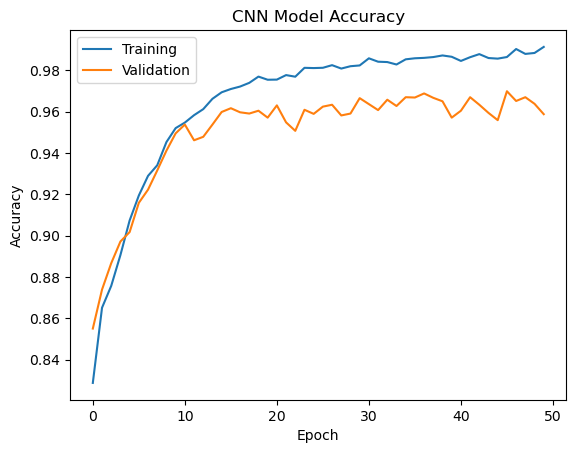

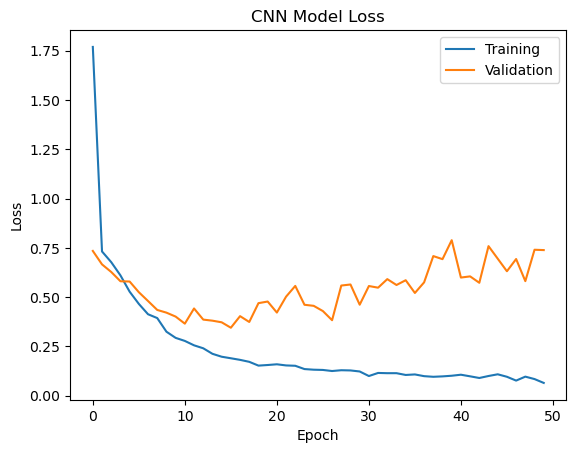

In [35]:
# Plot the training and validation accuracy
plt.plot(history1['accuracy'])
plt.plot(history1['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('cnn_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history1['loss'])
plt.plot(history1['val_loss'])
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('cnn_loss.png', dpi=300) # Save plot as PNG
plt.show()

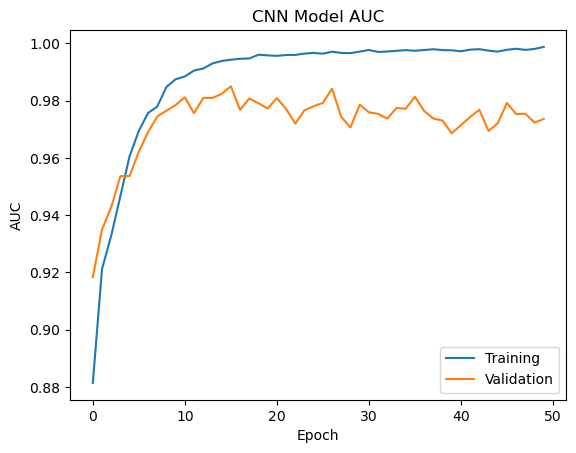

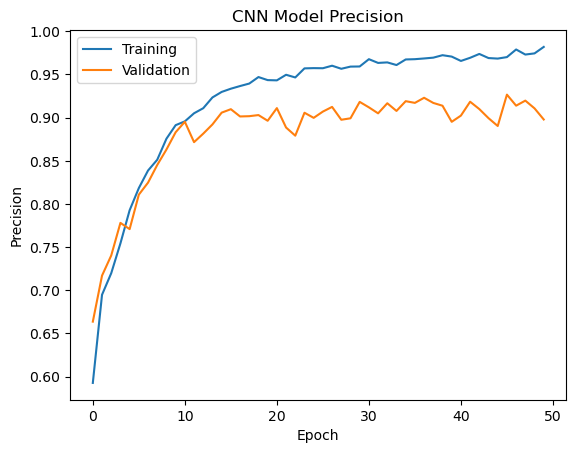

In [36]:
# Plot the training and validation auc
plt.plot(history1['auc'])
plt.plot(history1['val_auc'])
plt.title('CNN Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('cnn_auc.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(history1['precision'])
plt.plot(history1['val_precision'])
plt.title('CNN Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('cnn_precision.png', dpi=300) # Save plot as PNG
plt.show()

## Efficient NetB7 Model

In [37]:
from tensorflow.keras.applications import EfficientNetB7

In [38]:
efficientnetB7= EfficientNetB7(include_top=False,weights='imagenet',input_shape=(image_size, image_size, 3))

258076736/258076736 [==============================] - 9s 0us/step


In [39]:
# Output of model

model2 = efficientnetB7.output
model2 = tf.keras.layers.GlobalAveragePooling2D()(model2)
model2 = tf.keras.layers.Dropout(0.5)(model2)
model2 = tf.keras.layers.Dense(5, activation='softmax')(model2)
model2 = tf.keras.models.Model(inputs=efficientnetB7.input, outputs=model2)

In [40]:
model2.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [41]:
history2 = model2.load_weights('/kaggle/input/model-training/Model Training/efficientb7.h5')

In [42]:
import pickle

with open('/kaggle/input/model-training/Model Training/efficientb7_history.pkl', 'rb') as f:
    history2 = pickle.load(f)


## Classification Report - Efficient Net B7

In [43]:
pred2 = model2.predict(xtest)
pred2 = np.argmax(pred2, axis=1)
actual_label2 = np.argmax(ytest, axis=1)
print(classification_report(actual_label2, pred2,target_names = labels_final))

177/177 [==============================] - 28s 121ms/step
              precision    recall  f1-score   support

          AD       0.96      0.97      0.97      2481
          CN       0.97      0.98      0.97      2603
        EMCI       0.77      0.72      0.75       130
        LMCI       0.67      0.65      0.66        43
         MCI       0.82      0.73      0.77       376

    accuracy                           0.95      5633
   macro avg       0.84      0.81      0.82      5633
weighted avg       0.95      0.95      0.95      5633



In [44]:
accuracy_score(actual_label2, pred2)

0.9515355938221196

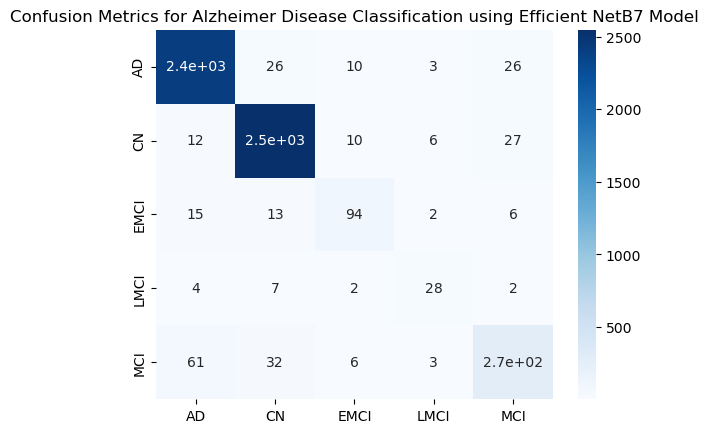

In [45]:
Cm2=confusion_matrix(actual_label2,pred2)
ax2=plt.axes()
sns.heatmap(Cm2, cmap='Blues' ,annot=True,
           annot_kws={'size':10},
           xticklabels=labels_final,
           yticklabels=labels_final,
           ax=ax2
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using Efficient NetB7 Model")
plt.savefig('netb7_confusion.png', dpi=300) # Save plot as PNG
plt.show()

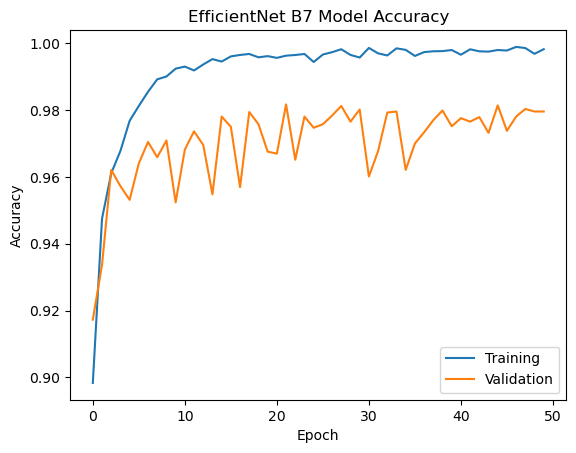

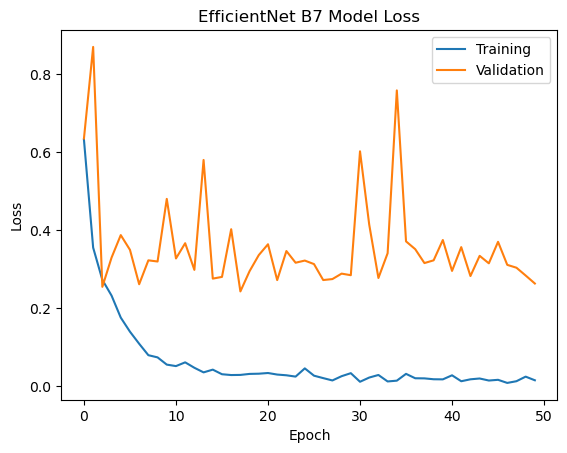

In [46]:
# Plot the training and validation accuracy
plt.plot(history2['accuracy'])
plt.plot(history2['val_accuracy'])
plt.title('EfficientNet B7 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('netb7_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history2['loss'])
plt.plot(history2['val_loss'])
plt.title('EfficientNet B7 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('netb7_loss.png', dpi=300) # Save plot as PNG
plt.show()

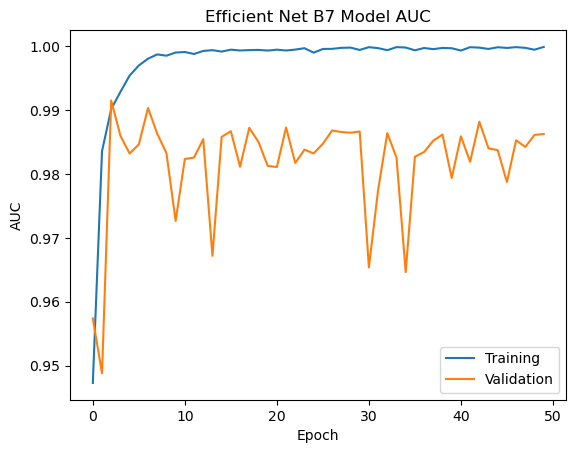

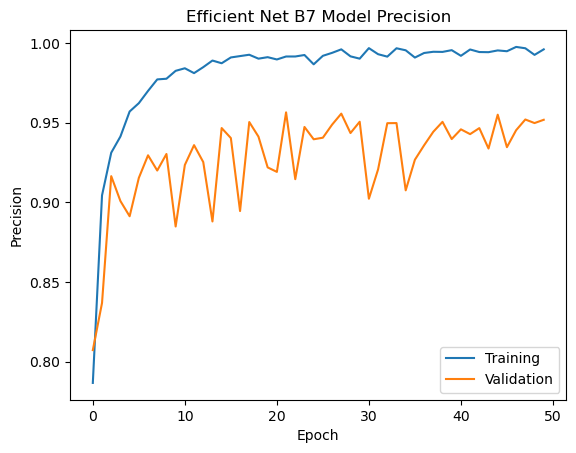

In [47]:
# Plot the training and validation auc
plt.plot(history2['auc'])
plt.plot(history2['val_auc'])
plt.title('Efficient Net B7 Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('netb7_auc.png', dpi=300) # Save plot as PNG

plt.show()

# Plot the training and validation precision
plt.plot(history2['precision'])
plt.plot(history2['val_precision'])
plt.title('Efficient Net B7 Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('netb7_precision.png', dpi=300) # Save plot as PNG
plt.show()

# VGG19 MODEL

In [48]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights='imagenet',
            include_top = False,input_shape=(image_size, image_size, 3)
           )
for layer in vgg.layers:
    layer.trainable = False
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model3 = Sequential()
model3.add(vgg)
model3.add(Flatten())
model3.add(Dense(5,activation="softmax"))
#model.summary()

80134624/80134624 [==============================] - 3s 0us/step


## Compile VGG19 Model

In [49]:
model3.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [50]:
history3 = model3.load_weights('/kaggle/input/model-training/Model Training/vgg19.h5')

In [51]:
import pickle

with open('/kaggle/input/model-training/Model Training/vgg19_history.pkl', 'rb') as f:
    history3 = pickle.load(f)


## Classification Report - VGG19

In [52]:
pred3 = model3.predict(xtest)
pred3 = np.argmax(pred3, axis=1)
actual_label3 = np.argmax(ytest, axis=1)
print(classification_report(actual_label3, pred3, target_names = labels_final))

177/177 [==============================] - 8s 38ms/step
              precision    recall  f1-score   support

          AD       0.80      0.95      0.87      2481
          CN       0.94      0.82      0.88      2603
        EMCI       0.74      0.62      0.67       130
        LMCI       0.67      0.65      0.66        43
         MCI       0.83      0.57      0.68       376

    accuracy                           0.86      5633
   macro avg       0.80      0.72      0.75      5633
weighted avg       0.86      0.86      0.85      5633



In [53]:
accuracy_score(actual_label3, pred3)

0.8554944079531334

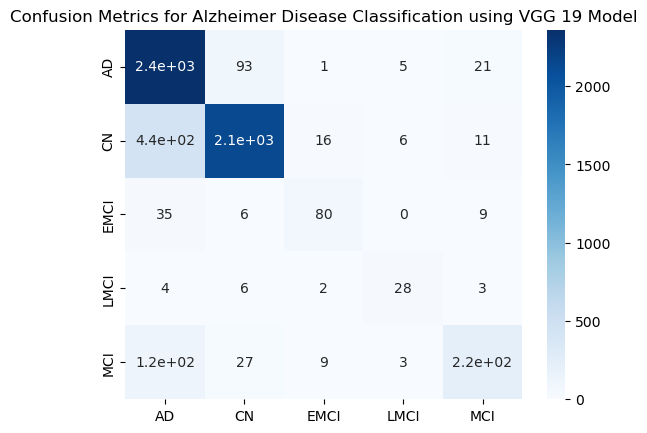

In [54]:
Cm3=confusion_matrix(actual_label3,pred3)
ax3=plt.axes()
sns.heatmap(Cm3, cmap='Blues' ,annot=True,
           annot_kws={'size':10},
           xticklabels=labels_final,
           yticklabels=labels_final,
           ax=ax3
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using VGG 19 Model")
plt.savefig('vgg19_confusion.png', dpi=300) # Save plot as PNG
plt.show()

## Loss and Accuracy Measurement Graph - VGG19 Model

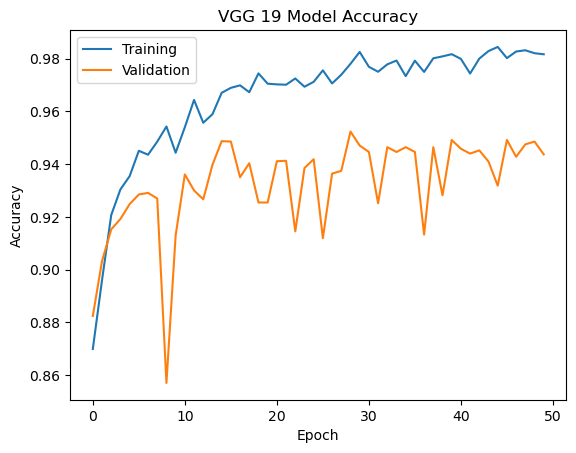

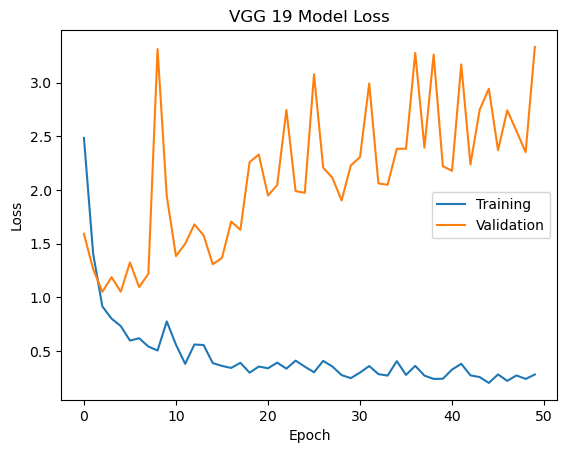

In [55]:
# Plot the training and validation accuracy
plt.plot(history3['accuracy'])
plt.plot(history3['val_accuracy'])
plt.title('VGG 19 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('vgg19_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history3['loss'])
plt.plot(history3['val_loss'])
plt.title('VGG 19 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('vgg19_loss.png', dpi=300) # Save plot as PNG
plt.show()

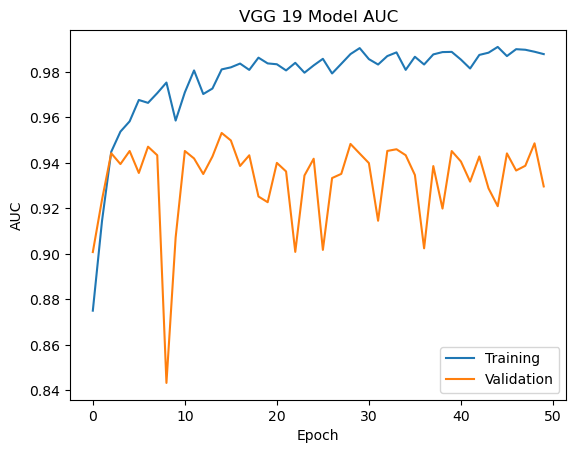

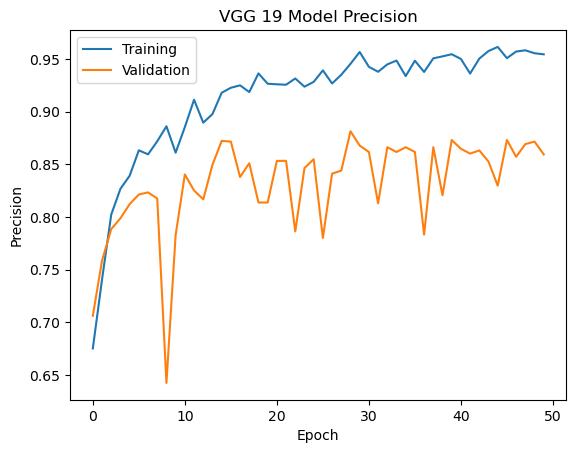

In [56]:
# Plot the training and validation auc
plt.plot(history3['auc'])
plt.plot(history3['val_auc'])
plt.title('VGG 19 Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('vgg19_auc.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(history3['precision'])
plt.plot(history3['val_precision'])
plt.title('VGG 19 Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('vgg19_precision.png', dpi=300) # Save plot as PNG
plt.show()

## Comparison and Graphs of Different Model Types

In [57]:
scores  = model.evaluate(xtest, ytest, verbose=1)
scores1 = model1.evaluate(xtest, ytest, verbose=1)
scores2 = model2.evaluate(xtest, ytest, verbose=1)
scores3 = model3.evaluate(xtest, ytest, verbose=1)


177/177 [==============================] - 8s 40ms/step - loss: 2.7220 - accuracy: 0.9657 - precision: 0.9155 - recall: 0.9127 - auc: 0.9719


## Densenet 

In [58]:
precision = scores[0]
f1_score = scores[1]
recall = scores[2]
accuracy = scores[3]

## CNN 

In [59]:
precision1 = scores1[0]
f1_score1 = scores1[1]
recall1 = scores1[2]
accuracy1 = scores1[3]

## Efficient Net B7 

In [60]:
precision2 = scores2[0]
f1_score2 = scores2[1]
recall2 = scores2[2]
accuracy2 = scores2[3]

## VGG 19 

In [61]:
precision3 = scores3[0]
f1_score3 = scores3[1]
recall3 = scores3[2]
accuracy3 = scores3[3]

In [62]:
import pandas as pd

eval_df = pd.DataFrame(columns=['Model','Precision', 'F1 Score', 'Recall', 'Accuracy'])


In [63]:
eval_df = eval_df.append({'Model' : 'Densenet', 'Precision': precision, 'F1 Score': f1_score, 'Recall': recall, 'Accuracy': accuracy}, ignore_index=True)
eval_df = eval_df.append({'Model' : 'CNN', 'Precision': precision1, 'F1 Score': f1_score1, 'Recall': recall1, 'Accuracy': accuracy1}, ignore_index=True)
eval_df = eval_df.append({'Model' : 'Efficient Net B7', 'Precision': precision2, 'F1 Score': f1_score2, 'Recall': recall2, 'Accuracy': accuracy2}, ignore_index=True)
eval_df = eval_df.append({'Model' : 'VGG 19', 'Precision': precision3, 'F1 Score': f1_score3, 'Recall': recall3, 'Accuracy': accuracy3}, ignore_index=True)


In [64]:
eval_df

,Model,Precision,F1 Score,Recall,Accuracy
0,Densenet,0.292761,0.975359,0.939961,0.936623
1,CNN,0.574751,0.969785,0.925672,0.923043
2,Efficient Net B7,0.224937,0.973537,0.935543,0.931889
3,VGG 19,2.722047,0.965684,0.915465,0.912702


In [65]:
import csv
eval_df.to_csv('comparison_metrics.csv', index=False)

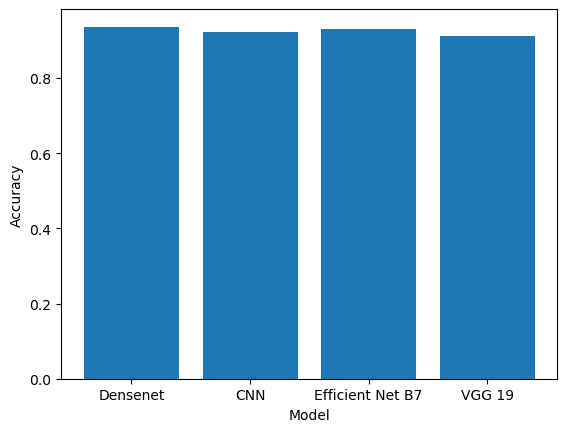

In [83]:
model_col = eval_df['Model']
accuracy_col = eval_df['Accuracy']

# Create a bar plot using matplotlib
fig, ax = plt.subplots()
ax.bar(model_col, accuracy_col)

# Set the x-axis and y-axis labels
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')

# Show the plot
plt.show()

## Ensemble Learning

In [66]:
pred = model.predict(xtest)
pred1=model1.predict(xtest)
pred2 = model2.predict(xtest)
pred3=model3.predict(xtest)
ensemble_preds = np.average([pred, pred1 ,pred2 ,pred3], axis=0)
final_preds = np.argmax(ensemble_preds, axis=1)
actual_label_final = np.argmax(ytest, axis=1)
print(classification_report(actual_label_final, final_preds,target_names = labels_final))

177/177 [==============================] - 7s 37ms/step
              precision    recall  f1-score   support

          AD       0.97      0.98      0.98      2481
          CN       0.96      0.99      0.97      2603
        EMCI       0.83      0.72      0.77       130
        LMCI       0.88      0.65      0.75        43
         MCI       0.92      0.77      0.84       376

    accuracy                           0.96      5633
   macro avg       0.91      0.82      0.86      5633
weighted avg       0.96      0.96      0.96      5633



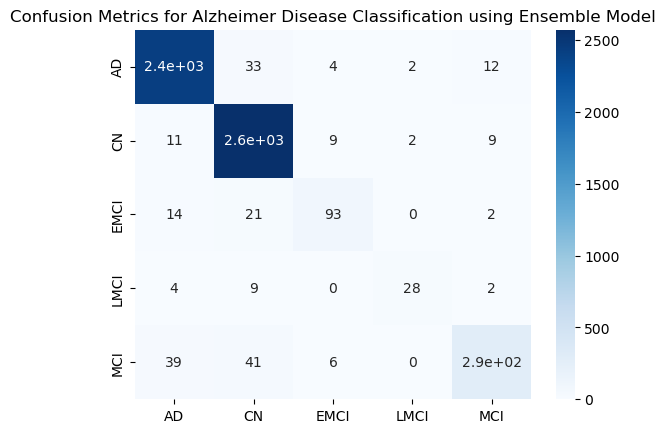

In [67]:
Cm4=confusion_matrix(actual_label_final,final_preds)
ax3=plt.axes()
sns.heatmap(Cm4, cmap='Blues' ,annot=True,
           annot_kws={'size':10},
           xticklabels=labels_final,
           yticklabels=labels_final,
           ax=ax3
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using Ensemble Model")
plt.savefig('ensemble_confusion.png', dpi=300) # Save plot as PNG
plt.show()

In [68]:
import pickle
with open('/kaggle/input/model-training/Model Training/ensemble_history.pkl', 'rb') as f:
    final = pickle.load(f)

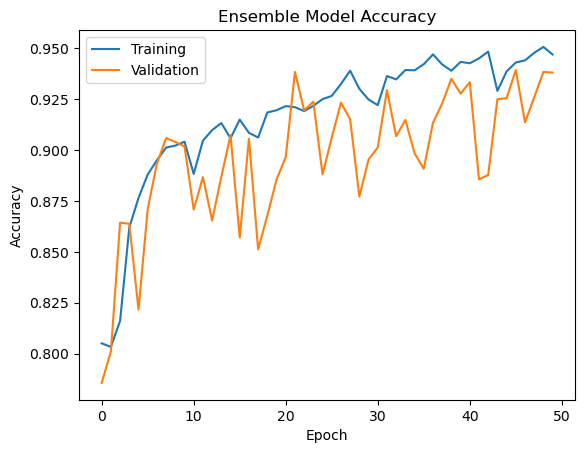

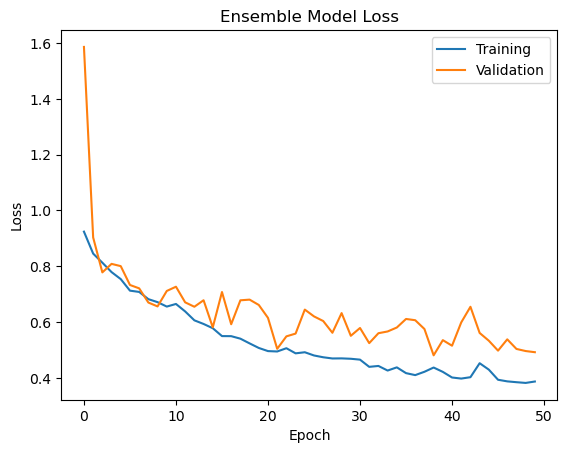

In [69]:
# Plot the training and validation accuracy
plt.plot(final['accuracy'])
plt.plot(final['val_accuracy'])
plt.title('Ensemble Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('ensemble_accuracy2.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(final['loss'])
plt.plot(final['val_loss'])
plt.title('Ensemble Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('ensemble_loss2.png', dpi=300) # Save plot as PNG
plt.show()

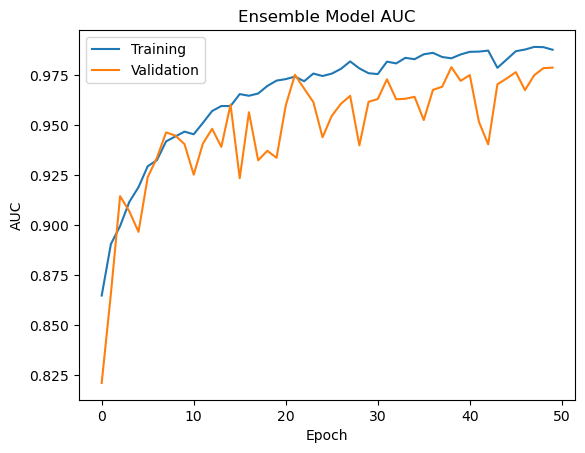

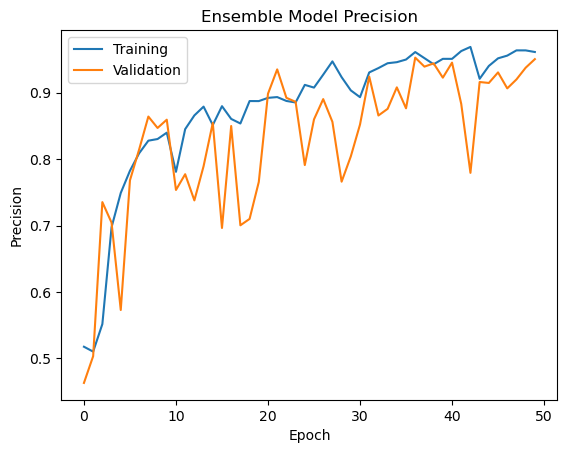

In [70]:
# Plot the training and validation auc
plt.plot(final['auc'])
plt.plot(final['val_auc'])
plt.title('Ensemble Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('ensemble_auc2.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(final['precision'])
plt.plot(final['val_precision'])
plt.title('Ensemble Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('ensemble_precision2.png', dpi=300) # Save plot as PNG
plt.show()

## Mean Square Error 

In [71]:
from sklearn.metrics import mean_squared_error

pred_final1 = (pred + pred1 + pred2 + pred3)/4.0
 
# printing the mean squared error between real value and predicted value
print(mean_squared_error(ytest, pred_final1))

0.014353122
